# ETL: Heurist database -> Pandas dataframe

## 1. Set up the environment

### Dependencies

In addition to `jupyterlab` and the `heurist` package, pip install the following:
- `ipywidgets` for seeing the progress bar in the notebook
- `seaborn` for visualising the data analysis

In [ ]:
!pip install ipywidgets seaborn

For this data analysis example, I want to use DuckDB's nightly build to take advantage of a new date function.

In [ ]:
 !pip install --upgrade duckdb --pre --upgrade

### Credentials

Either get your authentication credentials from a `.env` file or directly type them into the cell.

**Do not** directly type in your credentials if you're sharing the notebook with anyone / saving it somewhere public.

In [1]:
import os
from dotenv import load_dotenv

load_dotenv() 

HEURIST_DATABASE = os.getenv("DB_NAME")
HEURIST_LOGIN = os.getenv("DB_LOGIN")
HEURIST_PASSWORD = os.getenv("DB_PASSWORD")

## 2. Set up the Python objects

### API Client

Using your authentication credentials, create an instance of the Python API client.

In [2]:
from heurist.api.client import HeuristAPIClient

client = HeuristAPIClient(
    database_name = HEURIST_DATABASE,
    login = HEURIST_LOGIN,
    password = HEURIST_PASSWORD
)

### DuckDB connection

Create a DuckDB database connection. In this case, we'll create an in-memory connection that will disappear after this notebook is closed.

If you want to save the created DuckDB database, enter a file path in the `connect()` method, i.e. `duckdb.connect("heurist.db")`

In [3]:
import duckdb

conn = duckdb.connect()

## 3. Run the ETL workflow

Using the created API client and the DuckDB connection, run the ETL workflow.

By default, without specifying anything, the function collects records from your "My record types" group in Heurist.

If you want to collect records from additional groups, i.e. "Place, features," use the `record_group_names` parameter, as shown below:

```python
extract_transform_load(
    client = client,
    duckdb_connection = conn,
    record_group_names = ("My record types", "Place, features")
)
```

Based on the type of analysis you want to do, adjust the record groups targeted for extraction.

In [4]:
from heurist.workflows import extract_transform_load

extract_transform_load(
    client = client,
    duckdb_connection = conn,
)

Output()

Output()

### Look at the results

Use DuckDB's `"show tables;"` SQL query to review the tables the ETL workflow created.

In [5]:
conn.sql("show tables")

┌───────────────┐
│     name      │
│    varchar    │
├───────────────┤
│ Digitization  │
│ DocumentTable │
│ Footnote      │
│ Genre         │
│ Images        │
│ Part          │
│ PhysDesc      │
│ Repository    │
│ Scripta       │
│ Stemma        │
│ Story         │
│ Storyverse    │
│ TextTable     │
│ Witness       │
│ dty           │
│ rst           │
│ rtg           │
│ rty           │
│ trm           │
├───────────────┤
│    19 rows    │
└───────────────┘

Use DuckDB's `.df()` method to convert a table (technically a "relation" in SQL jargon) into a Pandas dataframe.

In [6]:
wit_df = conn.table("Witness").df()
wit_df

,H-ID,type_id,is_manifestation_of H-ID,observed_on_pages H-ID,last_observed_in_doc H-ID,is_unobserved,is_unobserved TRM-ID,claim_freetext,used_to_follow_fragment H-ID,used_to_follow_witness H-ID,...,number_of_hands,scribe_note,place_of_creation H-ID,place_of_creation_source,described_by_source H-ID,described_at_URL,reference_notes,review_status,review_status TRM-ID,review_note
0,47500,105,47473,[47501],47498.0,No,9483,None,<NA>,<NA>,...,NaN,None,[],<NA>,[47483],[https://www.handschriftencensus.de/9746],None,Action required,9697,Check.
1,47897,105,47896,[47898],NaN,No,9483,None,<NA>,<NA>,...,NaN,None,[],<NA>,[47483],[https://www.kb.nl/ontdekken-bewonderen/topstu...,None,Action required,9697,Check.
2,47756,105,47755,[47757],NaN,No,9483,None,<NA>,<NA>,...,1.0,None,[],<NA>,[47483],[https://opac.kbr.be/Library/search.aspx?SC=KB...,None,Action required,9697,Check.
3,47978,105,47977,[47979],NaN,No,9483,None,<NA>,<NA>,...,NaN,None,[],<NA>,[47483],[https://digitalcollections.universiteitleiden...,None,Action required,9697,Check.
4,47552,105,47548,[47553],47550.0,No,9483,None,<NA>,<NA>,...,2.0,None,[],<NA>,[47483],[https://www.handschriftencensus.de/21936],None,Action required,9697,Check.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,48051,105,48049,[48052],NaN,Yes,9482,Lost in bombing of the city in 1940.,<NA>,<NA>,...,NaN,None,[],<NA>,[47483],[https://www.arlima.net/eh/huon_de_bordeaux/nl...,None,Action required,9697,Kienhorst zegt in BNM?
169,47458,105,47293,[47459],47457.0,Yes,9482,Fragments have at least been lost since 1985.,<NA>,<NA>,...,NaN,None,[],<NA>,[],[https://www.handschriftencensus.de/18870],None,Action required,9697,Ref.
170,47454,105,47293,[47455],47453.0,Yes,9482,Fragment lost in 1914.,<NA>,<NA>,...,NaN,None,[],<NA>,[],[],None,Action required,9697,Ref.
171,47433,105,46322,[47434],47432.0,Yes,9482,None,<NA>,<NA>,...,NaN,None,[],<NA>,[],[],None,Action required,9697,"Check, ref."


## 4. Data analysis

#### Problem

My database's Witness records have a `date_of_creation`.

The dates are often fuzzy, which the `heurist` ETL workflow parsed and summarised as date ranges.

#### Question

How precise are my Witness records' dates?

In [7]:
# Calculate the number of seconds in a year
60 * 60 * 24 * 365

31536000

In [8]:
sql = """
SELECT
    epoch(w.date_of_creation[2] - w.date_of_creation[1]) / 31536000 as wit_precision_in_years,
    date_part('year', list_aggregate(w.date_of_creation, 'avg')) as wit_median_year,
    date_part('decade', list_aggregate(w.date_of_creation, 'avg')) as wit_decade,
    date_part('year', list_aggregate(t.date_of_creation, 'avg')) as text_median_year,
    date_part('decade', list_aggregate(t.date_of_creation, 'avg')) as text_decade,
    wit_decade - text_decade estimated_decades_since_text,
    g.preferred_name as genre
FROM Witness w
LEFT JOIN TextTable t
    ON w."is_manifestation_of H-ID" = t."H-ID"
LEFT JOIN Genre g
    ON t."specific_genre H-ID" = g."H-ID"
WHERE t.language_COLUMN like 'dum%'
"""
conn.sql(sql).df()

,wit_precision_in_years,wit_median_year,wit_decade,text_median_year,text_decade,estimated_decades_since_text,genre
0,25.013699,1323,132,1280,128,4,Arthurroman
1,30.016438,1406,140,1315,131,9,Other
2,20.010959,1325,132,1225,122,10,Arthurroman
3,45.024658,1313,131,1275,127,4,Other
4,20.010959,1423,142,1262,126,16,Arthurroman
...,...,...,...,...,...,...,...
164,20.010959,1325,132,1275,127,5,Arthurroman
165,20.008219,1300,130,1205,120,10,None
166,220.139726,1400,140,1270,127,13,None
167,220.139726,1400,140,1270,127,13,None


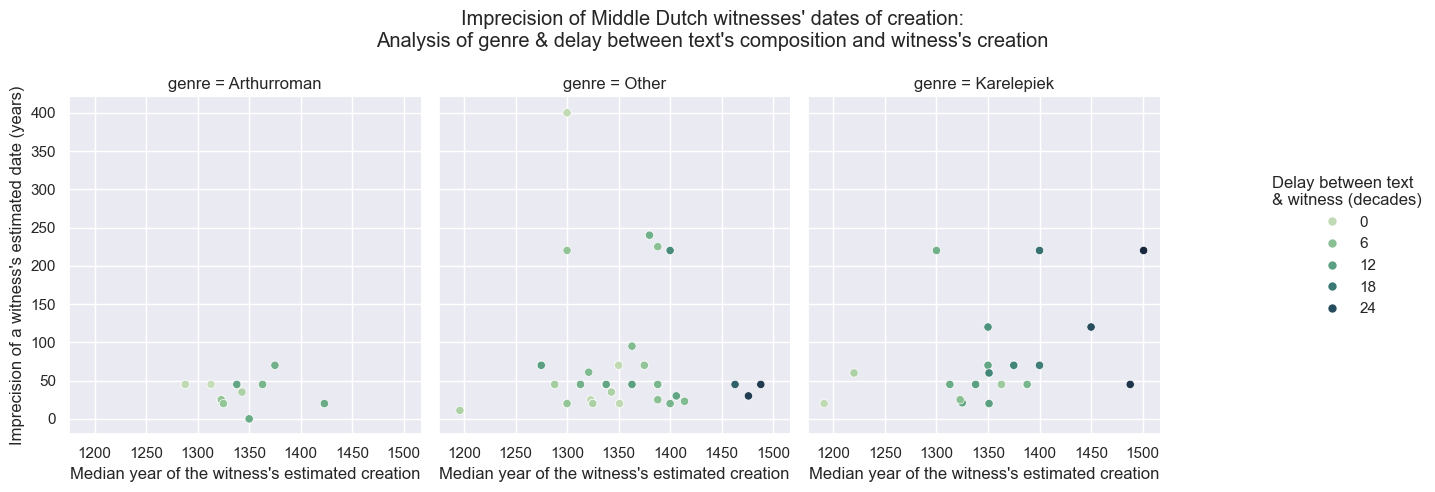

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relation and convert it to a pandas dataframe 
df = conn.sql(sql).df()

cmap = sns.cubehelix_palette(rot=-.5, as_cmap=True)
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

# Create a scatter plot to view each witness's date distribution and precision
graph = sns.relplot(
    data=df,
    x="wit_median_year",
    y="wit_precision_in_years",
    hue="estimated_decades_since_text",
    col="genre",
    palette=cmap,
    height=5,
    aspect=0.8,
)

# Set labels
graph.tick_params(axis="x", labelbottom=True)
graph.set_ylabels("Imprecision of a witness's estimated date (years)")
graph.set_xlabels("Median year of the witness's estimated creation")
graph._legend.set_title("Delay between text\n& witness (decades)")

graph.fig.suptitle("""Imprecision of Middle Dutch witnesses' dates of creation:
Analysis of genre & delay between text's composition and witness's creation""")

graph.tight_layout()